# ts_phosim

In [9]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import rcParams

rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

It seems that the failing tests are in https://tssw-ci.lsst.org/job/LSST_Telescope-and-Site/job/ts_phosim/job/develop/612/consoleFull 
    
    =================================== FAILURES ===================================
    __________ TestCreatePhosimDonutTemplates.testCutOutTemplatesAndSave ___________

    self = <test_createPhosimDonutTemplates.TestCreatePhosimDonutTemplates testMethod=testCutOutTemplatesAndSave>

    def testCutOutTemplatesAndSave(self):
    
        # Move centroid file into place
        self.createPhosimDonuts.createWorkDirectories()
        self._copyPhosimFiles()
        self.createPhosimDonuts.ingestImages()
        # Run the ISR
        self.createPhosimDonuts.runISR("")
    
        intraIdList, extraIdList = self.createPhosimDonuts.generateDataIdLists(
            9006002, 9006001
        )
        self.createPhosimDonuts.cutOutTemplatesAndSave(
            240,
            DefocalType.Extra,
            extraIdList,
        )
    
        newTemplate = np.genfromtxt(
            os.path.join(self.templateDir, "extra_template-R22_S10.txt")
        )
        trueTemplate = np.genfromtxt(
            os.path.join(
                self.testDataDir, "testDonutTemplates", "extra_template-R22_S10.txt"
            )
        )
    >       np.testing.assert_array_equal(newTemplate, trueTemplate)
    E       AssertionError: 
    E       Arrays are not equal
    E       
    E       Mismatched elements: 64 / 57600 (0.111%)
    E       Max absolute difference: 1.
    E       Max relative difference: 0.
    E        x: array([[0., 0., 0., ..., 0., 0., 0.],
    E              [0., 0., 0., ..., 0., 0., 0.],
    E              [0., 0., 0., ..., 0., 0., 0.],...
    E        y: array([[0., 0., 0., ..., 0., 0., 0.],
    E              [0., 0., 0., ..., 0., 0., 0.],
    E              [0., 0., 0., ..., 0., 0., 0.],...

    tests/utils/test_createPhosimDonutTemplates.py:197: AssertionError

So I try to reproduce that, and check what does this test actually does... 

https://github.com/lsst-ts/ts_phosim/blob/develop/tests/utils/test_createPhosimDonutTemplates.py  

In [2]:
import unittest
import os
import shutil
import tempfile
import numpy as np

from lsst.ts.phosim.utils.CreatePhosimDonutTemplates import CreatePhosimDonutTemplates
from lsst.ts.wep.Utility import DefocalType
from lsst.ts.phosim.utils.Utility import getConfigDir, getModulePath

# parts of setUp 
modulePath = getModulePath()
testDataDir = os.path.join(modulePath, "tests", "testData")

# Location where phosim input files exist.
# Also where temp work directory is created.
templateDataDir = os.path.join(getConfigDir(), "donutTemplateData")

# Location where templates are created
templateDir = os.path.join(templateDataDir, "phosimTemplates")

# Temporary work directory inside ts_wep/tests/
testDir = os.path.join(modulePath, "tests")
tempTestDirectory = tempfile.TemporaryDirectory(dir=testDir)
tempWorkDir = tempTestDirectory.name
createPhosimDonuts = CreatePhosimDonutTemplates(tempWorkDir)

In [3]:

def _copyPhosimFiles(testDataDir,tempWorkDir):

    # copy the raw amp image file
    shutil.copy(
        os.path.join(
            testDataDir,
            "testDonutTemplates",
            "phosimOutput",
            "MC_H_20211231_006001_R22_S10.fits",
        ),
        os.path.join(tempWorkDir, "raw", "MC_H_20211231_006001_R22_S10.fits"),
    )

    # copy the centroid file ( for a different visit )
    shutil.copy(
        os.path.join(
            testDataDir,
            "testDonutTemplates",
            "phosimOutput",
            "centroid_lsst_e_9006001_f1_R22_S10_E000.txt",
        ),
        os.path.join(tempWorkDir, "phosimOutput", "extra"),
    )

    # parts of testCutOutTemplatesAndSave
createPhosimDonuts.createWorkDirectories()
_copyPhosimFiles(testDataDir,tempWorkDir)
createPhosimDonuts.ingestImages()

Making temporary work directories
Ingest images


lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTCam:MC_H_20211231_006001 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset


In [4]:
# Run the ISR
createPhosimDonuts.runISR("")

intraIdList, extraIdList = createPhosimDonuts.generateDataIdLists(
    9006002, 9006001
)
createPhosimDonuts.cutOutTemplatesAndSave(
    240,
    DefocalType.Extra,
    extraIdList,
)

Running ISR


lsst.ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 1 quanta for 1 tasks, graph ID: '1669062570.2852154-1483569'
Quanta Tasks
------ -----
     1   isr
lsst.isr INFO: Converting exposure to floating point values.
lsst.isr INFO: Assembling CCD from amplifiers.
lsst.isr INFO: Widening saturation trails.
lsst.isr INFO: Applying gain correction instead of flat.
lsst.isr WARNING: No rough magnitude zero point defined for filter g.
lsst.isr INFO: Setting rough magnitude zero point for filter g: 30.940228
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'isr' on quantum {instrument: 'LSSTCam', detector: 93, exposure: 4021123106001, ...} took 5.575 seconds
lsst.ctrl.mpexec.mpGraphExecutor INFO: Executed 1 quanta successfully, 0 failed and 0 remain out of total 1 quanta.


In [5]:
newTemplate = np.genfromtxt(
            os.path.join(templateDir, "extra_template-R22_S10.txt")
        )

In [10]:
trueTemplate = np.genfromtxt(
            os.path.join(
                testDataDir, "testDonutTemplates", "extra_template-R22_S10.txt"
            ))

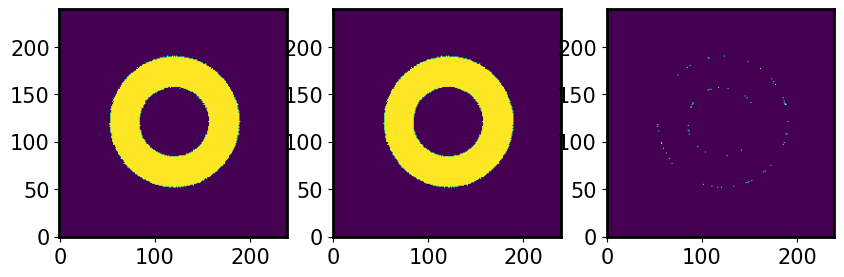

In [13]:

%matplotlib inline
fig,ax = plt.subplots(1,3,figsize=(10,6))
ax[0].imshow(newTemplate, origin='lower')
ax[1].imshow(trueTemplate, origin='lower')
ax[2].imshow(newTemplate-trueTemplate, origin='lower')

In [14]:
np.shape(newTemplate)

(240, 240)

In [15]:
np.shape(trueTemplate)

(240, 240)

There are **tiny** differences in the fuzyness of the edges. Look at the close-up:

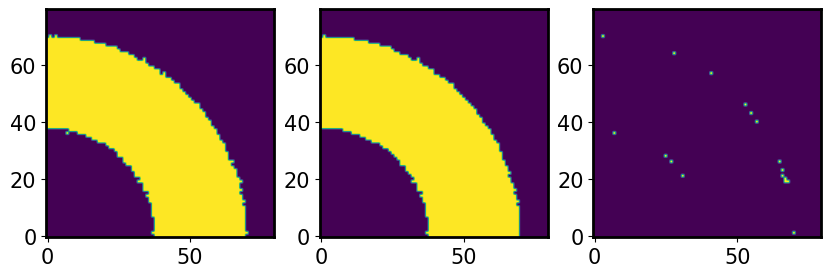

In [17]:
fig,ax = plt.subplots(1,3,figsize=(10,6))
xmin,xmax = 120,200
ymin,ymax = 120,200
new = newTemplate[ymin:ymax, xmin:xmax]
true = trueTemplate[ymin:ymax, xmin:xmax]
ax[0].imshow(new, origin='lower')
ax[1].imshow(true, origin='lower')
ax[2].imshow(new-true, origin='lower')

It's within few pixels. I think we either need to update the test image, or make the test less strict (currently it uses )

    np.testing.assert_array_equal(newTemplate, trueTemplate)

In [18]:
np.sum(newTemplate-trueTemplate)

64.0

# ts_wep  failing tests

For ts_wep, failures are  https://tssw-ci.lsst.org/job/LSST_Telescope-and-Site/job/ts_wep/job/develop/470/execution/node/49/log/  
    
    `TestCutOutDonutsCwfsTask` and `test_generateDonutDirectDetectTask.py`
    
The first one is https://github.com/lsst-ts/ts_wep/blob/develop/tests/task/test_cutOutDonutsCwfsTask.py and the second one is  https://github.com/lsst-ts/ts_wep/blob/develop/tests/task/test_generateDonutDirectDetectTask.py 
    
    
    =================================== FAILURES ===================================
    ____________________ TestCutOutDonutsCwfsTask.testPipeline _____________________

    self = <test_cutOutDonutsCwfsTask.TestCutOutDonutsCwfsTask testMethod=testPipeline>

    def testPipeline(self):
    
        (
            exposureExtra,
            exposureIntra,
            donutCatalogExtra,
            donutCatalogIntra,
            camera,
        ) = self._getDataFromButler()
    
        # Test normal behavior
        taskOut = self.task.run(
            [exposureIntra, exposureExtra],
            [donutCatalogExtra, donutCatalogIntra],
            camera,
        )
    
        donutStampsExtra = self.butler.get(
            "donutStampsExtra", dataId=self.dataIdExtra, collections=[self.runName]
        )
        donutStampsIntra = self.butler.get(
            "donutStampsIntra", dataId=self.dataIdExtra, collections=[self.runName]
        )
    
        for butlerStamp, taskStamp in zip(donutStampsExtra, taskOut.donutStampsExtra):
    m>           self.assertMaskedImagesAlmostEqual(butlerStamp.stamp_im, taskStamp.stamp_im)




then

    test_generateDonutDirectDetectTask.TestGenerateDonutDirectDetectTask 
    ...
    >       self.assertCountEqual(
                [3196, 2198, 2196, 3197],
                outputDf["centroid_y"],
            )
    E       AssertionError: Element counts were not equal:
    E       First has 1, Second has 0:  3196
    E       First has 1, Second has 0:  2196
    E       First has 1, Second has 2:  3197
    E       First has 0, Second has 1:  2195

    tests/task/test_generateDonutDirectDetectTask.py:154: AssertionError

In [1]:
import os
import numpy as np
from scipy.signal import correlate

import lsst.utils.tests
from lsst.afw import image as afwImage
from lsst.daf import butler as dafButler
from lsst.ts.wep.task.CutOutDonutsCwfsTask import (
    CutOutDonutsCwfsTask,
    CutOutDonutsCwfsTaskConfig,
)
from lsst.ts.wep.Utility import (
    getModulePath,
    runProgram,
    DefocalType,
    writePipetaskCmd,
    writeCleanUpRepoCmd,
)

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Run the pipeline once 

In [64]:
# def setUpClass():
#     """
#     Run the pipeline only once since it takes a
#     couple minutes with the ISR.
#     """

moduleDir = getModulePath()
testDataDir = os.path.join(moduleDir, "tests", "testData")
testPipelineConfigDir = os.path.join(testDataDir, "pipelineConfigs")
repoDir = os.path.join(testDataDir, "gen3TestRepo")
runName = "run2"
# The visit number for the test data
visitNum = 4021123106000

# Check that run doesn't already exist due to previous improper cleanup
butler = dafButler.Butler(repoDir)
registry = butler.registry
collectionsList = list(registry.queryCollections())
if runName in collectionsList:
    cleanUpCmd = writeCleanUpRepoCmd(repoDir, runName)
    runProgram(cleanUpCmd)

# Point to the collections for the reference catalogs,
# the raw images and the camera model in the calib directory
# that comes from `butler write-curated-calibrations`.
collections = "refcats/gen2,LSSTCam/calib,LSSTCam/raw/all"
instrument = "lsst.obs.lsst.LsstCam"
cameraName = "LSSTCam"
pipelineYaml = os.path.join(
    testPipelineConfigDir, "testCutoutsCwfsPipeline.yaml"
)

pipeCmd = writePipetaskCmd(
    repoDir,
    runName,
    instrument,
    collections,
    pipelineYaml=pipelineYaml,
)
pipeCmd += f" -d 'exposure IN ({visitNum})'"
runProgram(pipeCmd)

The following RUN collections were removed:
run2
The following datasets were removed:
cutOutDonutsCwfsTask_config(1), cutOutDonutsCwfsTask_log(1), cutOutDonutsCwfsTask_metadata(1), donutCatalog(8), donutStampsExtra(4), donutStampsIntra(4), generateDonutCatalogWcsTask_config(1), generateDonutCatalogWcsTask_log(8), generateDonutCatalogWcsTask_metadata(8), isr_config(1), isr_log(8), isr_metadata(8), packages(1), postISRCCD(8)


lsst.ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 17 quanta for 3 tasks, graph ID: '1669067266.5908895-409872'
Quanta            Tasks           
------ ---------------------------
     8                         isr
     8 generateDonutCatalogWcsTask
     1        cutOutDonutsCwfsTask
lsst.obs.lsst.assembly WARNING: /sdf/group/rubin/ncsa-home/home/scichris/aos/ts_wep/tests/testData/gen3TestRepo/LSSTCam/raw/all/raw/20211231/MC_H_20211231_006000/raw_LSSTCam_g_MC_H_20211231_006000_R44_SW1_LSSTCam_raw_all.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(575, 2047)) v. (minimum=(0, 0), maximum=(543, 2047)))
lsst.isr INFO: Converting exposure to floating point values.
lsst.isr INFO: Assembling CCD from amplifiers.
lsst.isr INFO: Widening saturation trails.
lsst.isr INFO: Applying gain correction instead of flat.
lsst.isr WARNING: No rough magnitude zero point defined for filter g.
lsst.isr INFO: Setting rough magnitude zero point for filter g: 30.940228

lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader INFO: Loading reference objects from None in region bounded by [1.19363282, 1.31579644], [1.07125921, 1.30848845] RA Dec
lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader INFO: Loaded 2 reference objects
lsst.generateDonutCatalogWcsTask.referenceSelector INFO: Selected 2/2 references
lsst.generateDonutCatalogWcsTask INFO: Running Donut Selector
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'generateDonutCatalogWcsTask' on quantum {instrument: 'LSSTCam', detector: 204, visit: 4021123106000, ...} took 0.629 seconds
lsst.ctrl.mpexec.mpGraphExecutor INFO: Executed 9 quanta successfully, 0 failed and 8 remain out of total 17 quanta.
lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader INFO: Loading reference objects from None in region bounded by [1.06440528, 1.18658036], [1.07120092, 1.30843556] RA Dec
lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader INFO: Loaded 2 refer

In [65]:
pipeCmd

"pipetask run -b /sdf/group/rubin/ncsa-home/home/scichris/aos/ts_wep/tests/testData/gen3TestRepo -i refcats/gen2,LSSTCam/calib,LSSTCam/raw/all --instrument lsst.obs.lsst.LsstCam --register-dataset-types --output-run run2 -p /sdf/group/rubin/ncsa-home/home/scichris/aos/ts_wep/tests/testData/pipelineConfigs/testCutoutsCwfsPipeline.yaml -d 'exposure IN (4021123106000)'"

    !more /sdf/group/rubin/ncsa-home/home/scichris/aos/ts_wep/tests/testData/pipelineConfigs/testCutoutsCwfsPipeline.yaml



    # This yaml file is used to define the tasks and configuration of
    # a Gen 3 pipeline used for testing in ts_wep.
    description: wep basic processing test pipeline
    # Here we specify the corresponding instrument for the data we
    # will be using.
    instrument: lsst.obs.lsst.LsstCam
    # Then we can specify each task in our pipeline by a name
    # and then specify the class name corresponding to that task
    tasks:
      isr:
        class: lsst.ip.isr.isrTask.IsrTask
        # Below we specify the configuration settings we want to use
        # when running the task in this pipeline. Since our data doesn't
        # include bias or flats we only want to use doApplyGains and
        # doOverscan in our isr task.
        config:
          connections.outputExposure: 'postISRCCD'
          doBias: False
          doVariance: False
          doLinearize: False
          doCrosstalk: False
          doDefect: False
          doNanMasking: False
          doInterpolate: False
          doBrighterFatter: False
          doDark: False
          doFlat: False
          doApplyGains: True
          doFringe: False
          doOverscan: True
      generateDonutCatalogWcsTask:
        class: lsst.ts.wep.task.GenerateDonutCatalogWcsTask.GenerateDonutCatalogWcsTask
        config:
          donutSelector.fluxField: 'g_flux'
          donutSelector.donutRadius: 0.0
      cutOutDonutsCwfsTask:
        class: lsst.ts.wep.task.CutOutDonutsCwfsTask.CutOutDonutsCwfsTask
        config:
          # And here we specify the configuration settings originally defined in
          # EstimateZernikesCwfsTaskConfig.
          # Test CWFS pipeline works when specifying instrument parameters.
          donutTemplateSize: 160
          donutStampSize: 160
          initialCutoutPadding: 40
          instObscuration: 0.61
          instFocalLength: 10.312
          instApertureDiameter: 8.36
          instDefocalOffset: 0.0
          instPixelSize: 10.0e-6


So the pipeline takes raw images, runs ISR, and then does donut detection... I notice that the settings now do include 

    config.overscan.fitType = "MEDIAN_PER_ROW"

and that now the postISR image show quite a bit of  horizontal lines (that probably weren't there before...)

I see from https://github.com/lsst/ip_isr/blob/9ca82378b826f0f4e6e871cad76685889cc3cda2/python/lsst/ip/isr/overscan.py#L42  that  of the allowed values, the default before was "MEDIAN".
 
     default='MEDIAN',
            allowed={
                "POLY": "Fit ordinary polynomial to the longest axis of the overscan region",
                "CHEB": "Fit Chebyshev polynomial to the longest axis of the overscan region",
                "LEG": "Fit Legendre polynomial to the longest axis of the overscan region",
                "NATURAL_SPLINE": "Fit natural spline to the longest axis of the overscan region",
                "CUBIC_SPLINE": "Fit cubic spline to the longest axis of the overscan region",
                "AKIMA_SPLINE": "Fit Akima spline to the longest axis of the overscan region",
                "MEAN": "Correct using the mean of the overscan region",
                "MEANCLIP": "Correct using a clipped mean of the overscan region",
                "MEDIAN": "Correct using the median of the overscan region",
                "MEDIAN_PER_ROW": "Correct using the median per row of the overscan region",
            },
        
So set that in the `yaml` file, and check if that helps... 

    python: OverscanCorrectionTask.ConfigClass.fitType = 'MEDIAN'

Read in the results of running the pipeline : 

In [104]:
# def setUp(self):
config = CutOutDonutsCwfsTaskConfig()
task = CutOutDonutsCwfsTask(config=config)

butler = dafButler.Butler(repoDir)
registry = butler.registry

dataIdExtra = {
    "instrument": "LSSTCam",
    "detector": 191,
    "exposure": visitNum,
    "visit": visitNum,
}
dataIdIntra = {
    "instrument": "LSSTCam",
    "detector": 192,
    "exposure": visitNum,
    "visit": visitNum,
}

testRunName = "testTaskRun"
collectionsList = list(registry.queryCollections())

In [133]:
collectionsList

['LSSTCam/raw/all',
 'refcats/gen2',
 'LSSTCam/calib',
 'LSSTCam/calib/unbounded',
 'LSSTComCam/calib',
 'LSSTComCam/calib/unbounded',
 'run2',
 'run1']

In [100]:
#def _getDataFromButler(butler,dataIdExtra,dataIdIntra,runName):

# Grab two exposures from the same visits of adjacent detectors
exposureExtra = butler.get(
    "postISRCCD", dataId=dataIdExtra, collections=[runName]
)
exposureIntra = butler.get(
    "postISRCCD", dataId=dataIdIntra, collections=[runName]
)
# Get the donut catalogs for each detector
donutCatalogExtra = butler.get(
    "donutCatalog", dataId=dataIdExtra, collections=[runName]
)
donutCatalogIntra = butler.get(
    "donutCatalog", dataId=dataIdIntra, collections=[runName]
)
# Get the camera from the butler
camera = butler.get(
    "camera",
    dataId={"instrument": "LSSTCam"},
    collections="LSSTCam/calib/unbounded",
)

#     return (
#         exposureExtra,
#         exposureIntra,
#         donutCatalogExtra,
#         donutCatalogIntra,
#         camera,
#     )

    
# (
# exposureExtra,
# exposureIntra,
# donutCatalogExtra,
# donutCatalogIntra,
# camera,
# ) = _getDataFromButler()

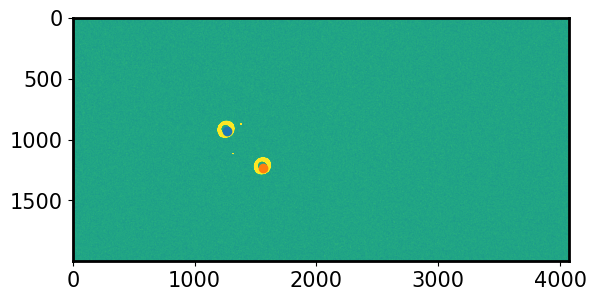

In [101]:
data = exposureIntra.image.array
zscale = ZScaleInterval()
vmin,vmax = zscale.get_limits(data)
plt.imshow(data, vmin=vmin,vmax=vmax)
for x,y in zip(donutCatalogIntra['centroid_x'].values,donutCatalogIntra['centroid_y'].values):
    #print(x,y)
    plt.scatter(x,y)

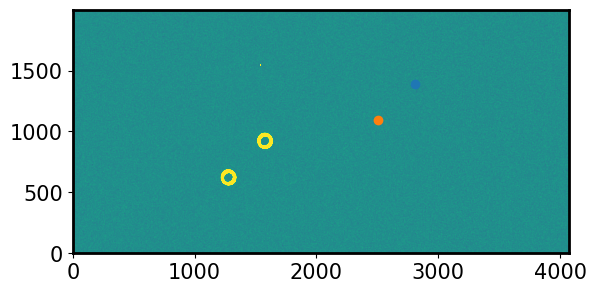

In [102]:
from astropy.visualization import ZScaleInterval
data = exposureExtra.image.array
zscale = ZScaleInterval()
vmin,vmax = zscale.get_limits(data)
plt.imshow(data, vmin=vmin,vmax=vmax, origin='lower')
for x,y in zip(donutCatalogExtra['centroid_x'].values,donutCatalogExtra['centroid_y'].values):
    #print(x,y)
    plt.scatter(x,y)

So both extra and intra images contain donuts! But the extra-focal image does not lead to donut detection. So need to figure out what's going on in `GenerateDonutCatalogWcsTask` (https://github.com/lsst-ts/ts_wep/blob/develop/tests/task/test_generateDonutCatalogWcsTask.py)

In [109]:
#Compare to the results of running a cutout task from the same images :

taskOut =task.run(
            [exposureIntra, exposureExtra],
            [donutCatalogExtra, donutCatalogIntra],
            camera,
        )

donutStampsExtra = butler.get(
    "donutStampsExtra", dataId=dataIdExtra, collections=[runName]
)
donutStampsIntra = butler.get(
    "donutStampsIntra", dataId=dataIdExtra, collections=[runName]
)



There are no extra-focal donuts:

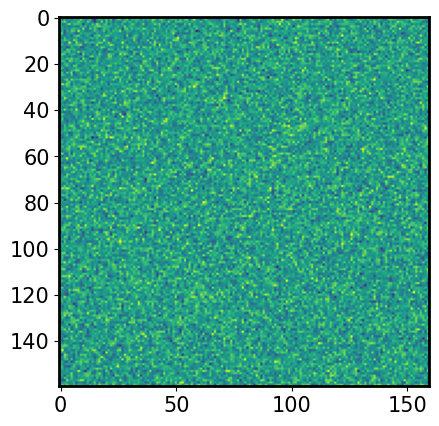

In [110]:
data = donutStampsExtra[0].stamp_im.getImage().array
vmin,vmax = zscale.get_limits(data)
plt.imshow(data,vmin=vmin,vmax=vmax)



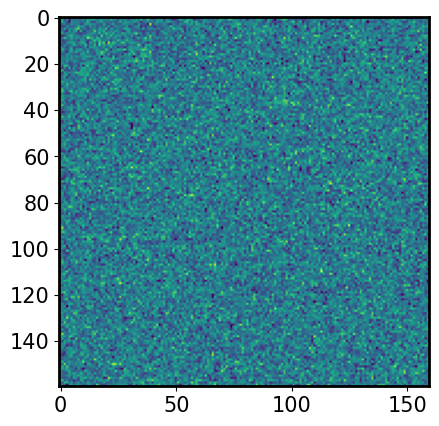

In [111]:
data = donutStampsExtra[1].stamp_im.getImage().array
vmin,vmax = zscale.get_limits(data)
plt.imshow(data,vmin=vmin,vmax=vmax)



But the intra-focal appear just fine:

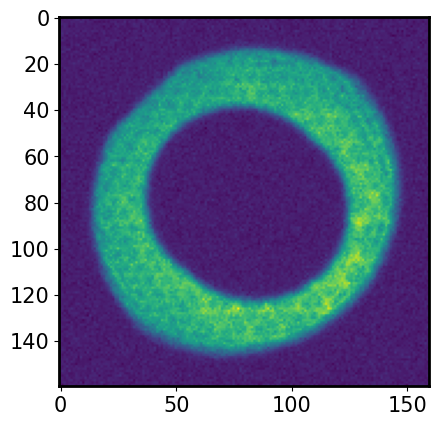

In [114]:
plt.imshow(taskOut.donutStampsIntra[0].stamp_im.getImage().array)



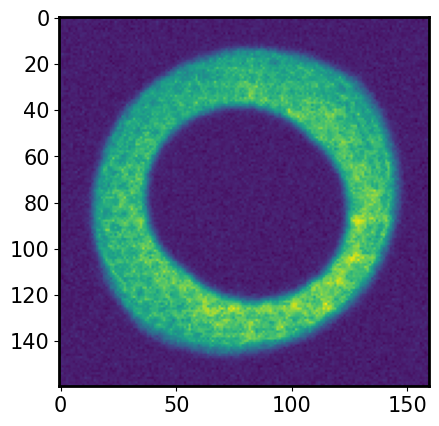

In [115]:
plt.imshow(taskOut.donutStampsIntra[1].stamp_im.getImage().array)



## Detect the donuts in corner sensors  in the notebook  (rather than by running the pipetask...)

In [2]:
# take the basic setup from the test for that task ... 
from lsst.ts.wep.task.GenerateDonutCatalogWcsTask import (
    GenerateDonutCatalogWcsTask,
    GenerateDonutCatalogWcsTaskConfig,
)
config = GenerateDonutCatalogWcsTaskConfig()
config.donutSelector.fluxField = "g_flux"
config.donutSelector.donutRadius = 0.0
task = GenerateDonutCatalogWcsTask(config=config)

GenerateDonutCatalogWcsTask  has the following signature:
    
    
     run(
        self,
        refCatalogs: typing.List[afwTable.SimpleCatalog],
        exposure: afwImage.Exposure,
    )
        
it needs refCats and exposures.  Provide those for  the corner sensors test repo as above... 

In [3]:
# def setUpClass():
#     """
#     Run the pipeline only once since it takes a
#     couple minutes with the ISR.
#     """

moduleDir = getModulePath()
testDataDir = os.path.join(moduleDir, "tests", "testData")
testPipelineConfigDir = os.path.join(testDataDir, "pipelineConfigs")
repoDir = os.path.join(testDataDir, "gen3TestRepo")
runName = "run2"
# The visit number for the test data
visitNum = 4021123106000

# Check that run doesn't already exist due to previous improper cleanup
butler = dafButler.Butler(repoDir)
registry = butler.registry
# collectionsList = list(registry.queryCollections())
# if runName in collectionsList:
#     cleanUpCmd = writeCleanUpRepoCmd(repoDir, runName)
#     runProgram(cleanUpCmd)

# # Point to the collections for the reference catalogs,
# # the raw images and the camera model in the calib directory
# # that comes from `butler write-curated-calibrations`.
# collections = "refcats/gen2,LSSTCam/calib,LSSTCam/raw/all"
# instrument = "lsst.obs.lsst.LsstCam"
# cameraName = "LSSTCam"
# pipelineYaml = os.path.join(
#     testPipelineConfigDir, "testCutoutsCwfsPipeline.yaml"
# )

# pipeCmd = writePipetaskCmd(
#     repoDir,
#     runName,
#     instrument,
#     collections,
#     pipelineYaml=pipelineYaml,
# )
# pipeCmd += f" -d 'exposure IN ({visitNum})'"
# runProgram(pipeCmd)

In [4]:
deferredList = []
datasetGenerator = registry.queryDatasets(
    datasetType="cal_ref_cat", collections=["refcats/gen2"]
).expanded()
for ref in datasetGenerator:
    deferredList.append(
        butler.getDeferred(ref, collections=["refcats/gen2"])
    )

# use the same exposure as above ...    
dataIdExtra = {
    "instrument": "LSSTCam",
        "detector": 191,
    "exposure": visitNum,
    "visit": visitNum,
}
exposureExtra = butler.get(
    "postISRCCD", dataId=dataIdExtra, collections=[runName]
)
dataIdIntra = {
    "instrument": "LSSTCam",
    "detector": 192,
    "exposure": visitNum,
    "visit": visitNum,
}
exposureIntra = butler.get(
    "postISRCCD", dataId=dataIdIntra, collections=[runName]
)

In [5]:
exposureExtra = butler.get(
    "postISRCCD", dataId=dataIdExtra, collections=[runName]
)

Eight, since we have eight corner sensors.. The extra-focal detector used  in the test is `"detector": 191,`:

In [129]:
exposure = expList[0]

In [120]:
exposure.getInfo().getId()

4021123106000191

In [6]:
taskOutputExtra = task.run(deferredList, exposureExtra)
taskOutputIntra = task.run(deferredList, exposureIntra)

INFO:lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader:Loading reference objects from None in region bounded by [358.81341964, 358.93559472], [-1.30843556, -1.07120092] RA Dec
INFO:lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader:Loaded 2 reference objects
INFO:lsst.generateDonutCatalogWcsTask.referenceSelector:Selected 2/2 references
INFO:lsst.generateDonutCatalogWcsTask:Running Donut Selector
INFO:lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader:Loading reference objects from None in region bounded by [358.68420356, 358.80636718], [-1.30848845, -1.07125921] RA Dec
INFO:lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader:Loaded 2 reference objects
INFO:lsst.generateDonutCatalogWcsTask.referenceSelector:Selected 2/2 references
INFO:lsst.generateDonutCatalogWcsTask:Running Donut Selector


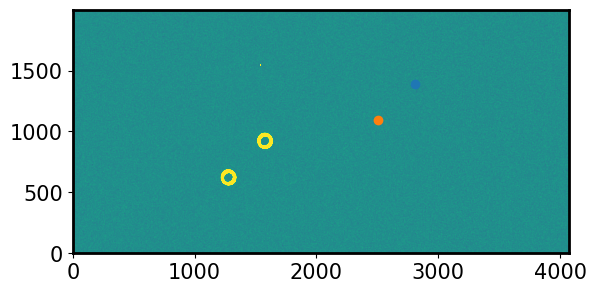

In [10]:
from astropy.visualization import ZScaleInterval
data = exposureExtra.image.array
zscale = ZScaleInterval()
vmin,vmax = zscale.get_limits(data)
plt.imshow(data, vmin=vmin,vmax=vmax, origin='lower')
for x,y in zip(taskOutputExtra.donutCatalog['centroid_x'].values,
               taskOutputExtra.donutCatalog['centroid_y'].values):
    #print(x,y)
    plt.scatter(x,y)

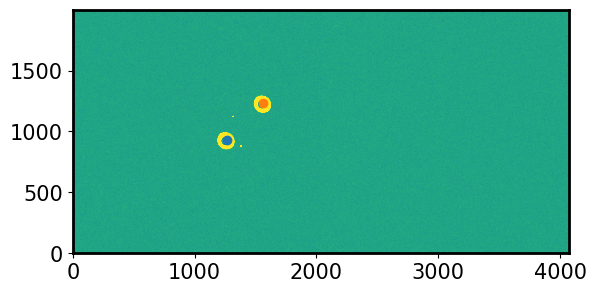

In [11]:
from astropy.visualization import ZScaleInterval
data = exposureIntra.image.array
zscale = ZScaleInterval()
vmin,vmax = zscale.get_limits(data)
plt.imshow(data, vmin=vmin,vmax=vmax, origin='lower')
for x,y in zip(taskOutputIntra.donutCatalog['centroid_x'].values,
               taskOutputIntra.donutCatalog['centroid_y'].values):
    #print(x,y)
    plt.scatter(x,y)

ok, so at least I can reproduce exactly the same problem. What can I tweak here to make the problem disappear?

## Compare that to the ref cat 

In [20]:
from astropy.table import Table
path = os.path.join(testDataDir,'skyRefCat.txt')
skyRefCat = Table.read(path, format='ascii')

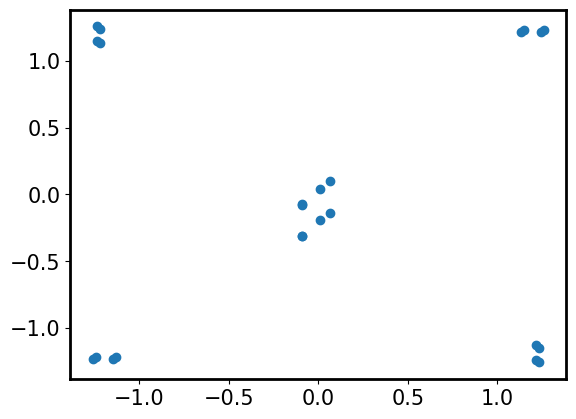

In [24]:
ra = skyRefCat['ra']
m = ra>180
ra[m] = ra[m]-360
plt.scatter(ra, skyRefCat['dec'])

plot the ra,dec attached to the exposure ...

In [25]:
from astropy.wcs import WCS
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import astropy.units as u

def plotRaDec(postIsrExp):
    
    """
    Plot the image data and the WCS overlay.
    
    Parameters
    ----------
    postIsrExp : lsst.afw.image.Exposure
        The post-ISR exposure from the butler repository.
    """
    # Get the WCS for the projection
    wcs = postIsrExp.getWcs()
    header_dict = dict(wcs.getFitsMetadata())
    
    # Add in axis information
    #header_dict['NAXIS'] = 2
    #header_dict['NAXIS1'] = 4072
    #header_dict['NAXIS2'] = 4000
    
    # Convert to astropy readable WCS
    astropyWcs = WCS(header_dict)
    
    # Grab image data and plot
    data = postIsrExp.getImage().getArray()
    zscale = ZScaleInterval()
    vmin, vmax = zscale.get_limits(data)

    plt.subplot(projection=astropyWcs)#, slices=('y', 'x'))
    plt.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys',)

    # Format coordinates presentation
    ax = plt.gca()

    # Fix axis label issue (https://github.com/astropy/astropy/issues/7180)
    ax.coords[0].set_ticklabel_position('l')
    ax.coords[0].grid(color='yellow')
    ax.set_ylabel('RA')
    
    ax.coords[1].set_ticklabel_position('b')
    ax.coords[1].grid(color='yellow')
    ax.set_xlabel('Dec')

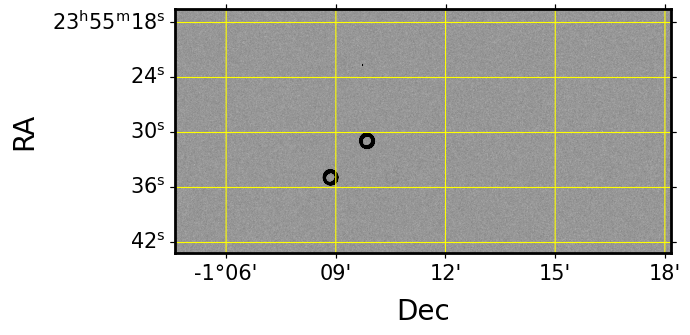

In [26]:
plotRaDec(exposureExtra)
plt.scatter(skyRefCat)

Given the WCS attached to the exposure, and the donut catalog, convert the ra,dec to x,y px and plot . I've used that for PS1 https://github.com/suberlak/AOS/blob/a2f06e82a813aa893ee175f3f59657d8734b4e8e/run_ps1_functions.py#L84 

In [27]:
wcs = exposureExtra.getWcs()

In [35]:
ra = skyRefCat['ra']
dec = skyRefCat['dec']
x,y = wcs.skyToPixelArray(ra,dec,degrees=True)

(0.0, 2000.0)

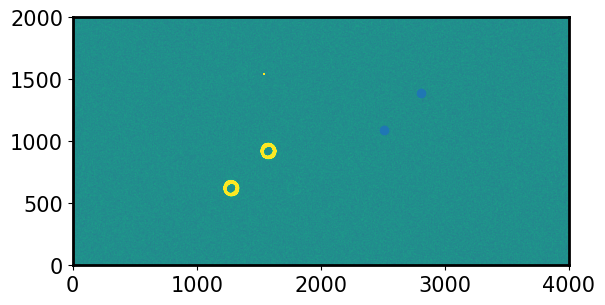

In [41]:
from astropy.visualization import ZScaleInterval
data = exposureExtra.image.array
zscale = ZScaleInterval()
vmin,vmax = zscale.get_limits(data)
plt.imshow(data, vmin=vmin,vmax=vmax, origin='lower')
plt.scatter(x,y)
plt.xlim(0,4000)
plt.ylim(0,2000)
# for x,y in zip(taskOutputExtra.donutCatalog['centroid_x'].values,
#                taskOutputExtra.donutCatalog['centroid_y'].values):
#     #print(x,y)
#     plt.scatter(x,y)

minimum code to reproduce the above:

(0.0, 2000.0)

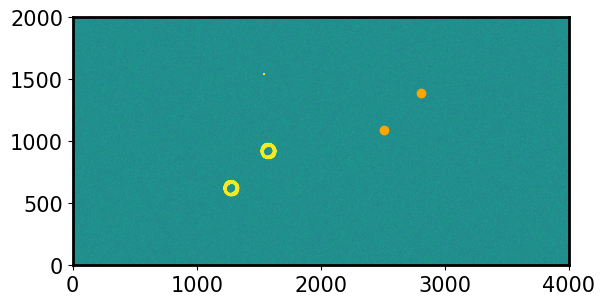

In [43]:
from astropy.visualization import ZScaleInterval
from astropy.table import Table

moduleDir = getModulePath()
testDataDir = os.path.join(moduleDir, "tests", "testData")
testPipelineConfigDir = os.path.join(testDataDir, "pipelineConfigs")
repoDir = os.path.join(testDataDir, "gen3TestRepo")
runName = "run2"
visitNum = 4021123106000

butler = dafButler.Butler(repoDir)
registry = butler.registry

dataIdExtra = {
    "instrument": "LSSTCam",
        "detector": 191,
    "exposure": visitNum,
    "visit": visitNum,}
exposureExtra = butler.get(
    "postISRCCD", dataId=dataIdExtra, collections=[runName])

wcs = exposureExtra.getWcs()


path = os.path.join(testDataDir,'skyRefCat.txt')
skyRefCat = Table.read(path, format='ascii')
ra = skyRefCat['ra']
dec = skyRefCat['dec']
x,y = wcs.skyToPixelArray(ra,dec,degrees=True)
data = exposureExtra.image.array
zscale = ZScaleInterval()
vmin,vmax = zscale.get_limits(data)
plt.imshow(data, vmin=vmin,vmax=vmax, origin='lower')
plt.scatter(x,y, c='orange')
plt.xlim(0,4000)
plt.ylim(0,2000)

Try rotating the WCS attached to the exposure... 

(0.0, 2000.0)

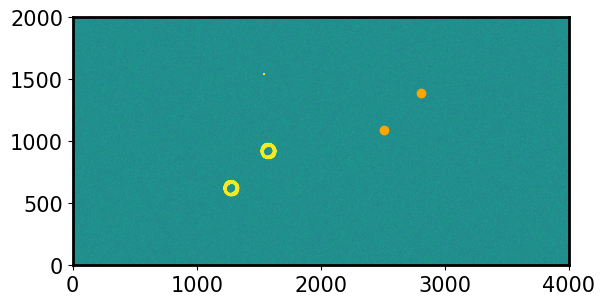

In [83]:
import lsst.geom
from lsst.afw.geom import makeSkyWcs,  makeCdMatrix

# Obtain sources from the reference catalog with the WCS rotated by 180 degrees
rotationInDeg = 180

info = exposureExtra.getInfo().getVisitInfo()
orientation = (info.getBoresightRotAngle().asDegrees()+rotationInDeg)* lsst.geom.degrees
#  info.getBoresightRotAngle()# 0 * lsst.geom.degrees  #

originalWcs = exposureExtra.getWcs()
flipX = originalWcs.isFlipped
scale =  originalWcs.getPixelScale() # 0.2 * lsst.geom.arcseconds  # how many arcsec per pixel
cdMatrix = makeCdMatrix(scale=scale, orientation=orientation, flipX=flipX)

pxOrigin = originalWcs.getPixelOrigin()

crpix = pxOrigin
crval = originalWcs.getSkyOrigin() # lsst.geom.SpherePoint(0.0*lsst.geom.degrees, 0.0*lsst.geom.degrees)
rotatedWcs = makeSkyWcs(crpix=crpix, crval=crval, cdMatrix=cdMatrix)

# plot using rotatedWcs
x,y = rotatedWcs.skyToPixelArray(ra,dec,degrees=True)
data = exposureExtra.image.array
zscale = ZScaleInterval()
vmin,vmax = zscale.get_limits(data)
plt.imshow(data, vmin=vmin,vmax=vmax, origin='lower')
plt.scatter(x,y, c='orange')
plt.xlim(0,4000)
plt.ylim(0,2000)

(0.0, 4000.0)

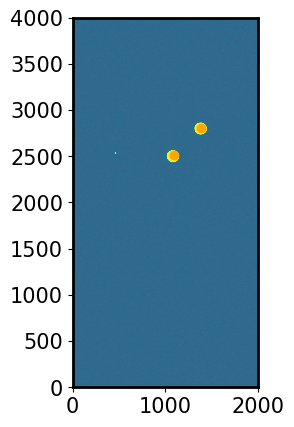

In [98]:
from scipy.ndimage import rotate
detector = exposureExtra.getDetector()
eulerZ = -detector.getOrientation().getYaw().asDegrees()
image = exposureExtra.getImage().array
rotatedImage = rotate(image, eulerZ).T

vmin,vmax = zscale.get_limits(rotatedImage)
plt.imshow(rotatedImage, origin='lower', vmin=vmin, vmax=vmax)
wcs =  exposureExtra.getWcs()
x,y = wcs.skyToPixelArray(ra,dec,degrees=True)
plt.scatter(y,x, c='orange')
plt.xlim(0,2000)
plt.ylim(0,4000)

(0.0, 4000.0)

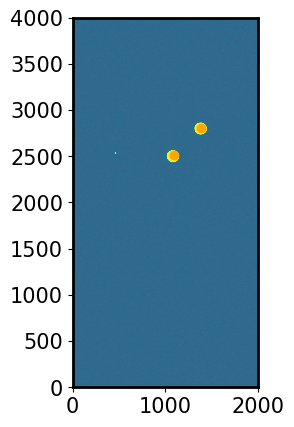

In [96]:
x

array([-21156.26491735, -20156.05615539, -17955.60734227, -18055.63364332,
       -16922.76364781, -15922.98289522, -13723.38614832, -13823.39723446,
       -41579.39472692, -41280.08552192,   2808.28034001,   2508.99546614,
       -41580.3111769 , -41280.90030552,   2807.2211201 ,   2507.98386759,
       -40049.21177448, -39749.89988167,   3277.08202521,   2977.75166695,
       -42045.58338715, -41746.30709433,   1283.42844069,    984.0624765 ])

In [ ]:
camera = donutExtra.getCamera() # same camera for both donuts
                    detectorExtra = camera.get(donutExtra.detector_name)
    eulerZExtra = -detectorExtra.getOrientation().getYaw().asDegrees()


# Running  test for generateDonutCatalogWcsTask

So the problem here is that the pipeline doesn't get the  donuts in the right places for the extra-focal corner sensors. 

How is it that the `test_generateDonutCatalogWcsTask.py` doesn't fail ?  Because it runs the same for the sensors in the center of the focal plane, which probably have much simpler geometry. 



In [86]:
runName = "run1"
instrument = "lsst.obs.lsst.LsstCam"
collections = "refcats/gen2,LSSTCam/calib,LSSTCam/raw/all"
exposureId = 4021123106001  # Exposure ID for test extra-focal image
moduleDir = getModulePath()
testDataDir = os.path.join(moduleDir, "tests", "testData")
repoDir = os.path.join(testDataDir, "gen3TestRepo")
    
    
testPipelineConfigDir = os.path.join(testDataDir, "pipelineConfigs")
pipelineYaml = os.path.join(
    testPipelineConfigDir, "testDonutCatWcsPipeline.yaml"
)
pipetaskCmd = writePipetaskCmd(
    repoDir, runName, instrument, collections, pipelineYaml=pipelineYaml
)
# Update task configuration to match pointing information
pipetaskCmd += f" -d 'exposure IN ({exposureId})'"

# Check that run doesn't already exist due to previous improper cleanup
butler = dafButler.Butler(repoDir)
registry = butler.registry
collectionsList = list(registry.queryCollections())
if runName in collectionsList:
    cleanUpCmd = writeCleanUpRepoCmd(repoDir, runName)
    runProgram(cleanUpCmd)

# Run pipeline task
runProgram(pipetaskCmd)

lsst.ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 4 quanta for 2 tasks, graph ID: '1669068721.6440096-2231299'
Quanta            Tasks           
------ ---------------------------
     2                         isr
     2 generateDonutCatalogWcsTask
lsst.isr INFO: Converting exposure to floating point values.
lsst.isr INFO: Assembling CCD from amplifiers.
lsst.isr INFO: Widening saturation trails.
lsst.isr INFO: Applying gain correction instead of flat.
lsst.isr WARNING: No rough magnitude zero point defined for filter g.
lsst.isr INFO: Setting rough magnitude zero point for filter g: 30.940228
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'isr' on quantum {instrument: 'LSSTCam', detector: 94, exposure: 4021123106001, ...} took 5.497 seconds
lsst.ctrl.mpexec.mpGraphExecutor INFO: Executed 1 quanta successfully, 0 failed and 3 remain out of total 4 quanta.
lsst.isr INFO: Converting exposure to floating point values.
lsst.isr INFO: Assembling CCD from amplifiers.


In [87]:
pipetaskCmd

"pipetask run -b /sdf/group/rubin/ncsa-home/home/scichris/aos/ts_wep/tests/testData/gen3TestRepo -i refcats/gen2,LSSTCam/calib,LSSTCam/raw/all --instrument lsst.obs.lsst.LsstCam --register-dataset-types --output-run run1 -p /sdf/group/rubin/ncsa-home/home/scichris/aos/ts_wep/tests/testData/pipelineConfigs/testDonutCatWcsPipeline.yaml -d 'exposure IN (4021123106001)'"

In [92]:
exposureId

4021123106001

In [88]:
pipelineButler = dafButler.Butler(repoDir)
donutCatDf_S11 = pipelineButler.get(
    "donutCatalog",
    dataId={"instrument": "LSSTCam", "detector": 94, "visit": exposureId},
    collections=[f"{runName}"],
)
donutCatDf_S10 = pipelineButler.get(
    "donutCatalog",
    dataId={"instrument": "LSSTCam", "detector": 93, "visit": exposureId},
    collections=[f"{runName}"],
)


show the donuts atop the exposure image... 

In [93]:
exposureS11= pipelineButler.get(
    "postISRCCD", dataId={"instrument": "LSSTCam", "detector": 94, "exposure": exposureId},
    collections=[f"{runName}"],)
exposureS10 = pipelineButler.get(
    "postISRCCD", dataId={"instrument": "LSSTCam", "detector": 93, "exposure": exposureId},
    collections=[f"{runName}"],)

Text(0.5, 1.0, 'S11')

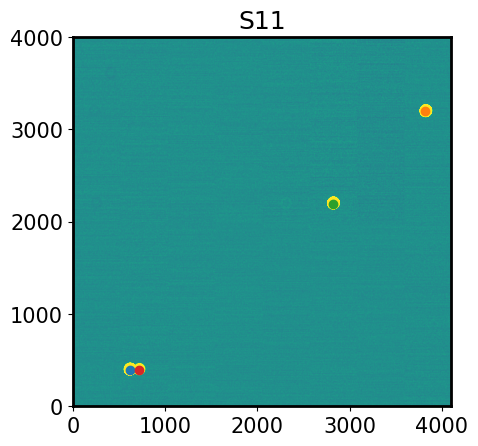

In [102]:
data = exposureS11.image.array
zscale = ZScaleInterval()
vmin,vmax = zscale.get_limits(data)
plt.imshow(data, vmin=vmin,vmax=vmax, origin='lower')
for x,y in zip(donutCatDf_S11['centroid_x'].values,donutCatDf_S11['centroid_y'].values):
    #print(x,y)
    plt.scatter(x,y)
plt.title('S11')

Text(0.5, 1.0, 'S10')

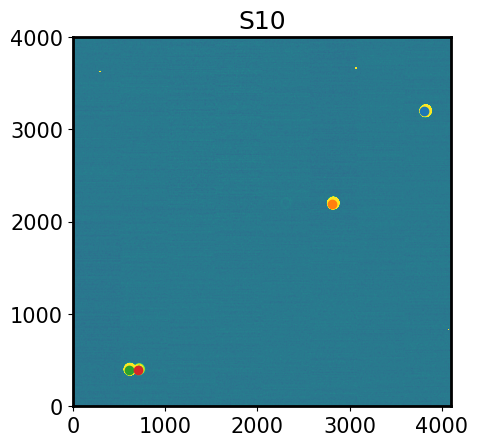

In [103]:
data = exposureS10.image.array
zscale = ZScaleInterval()
vmin,vmax = zscale.get_limits(data)
plt.imshow(data, vmin=vmin,vmax=vmax,origin='lower')
for x,y in zip(donutCatDf_S10['centroid_x'].values,donutCatDf_S10['centroid_y'].values):
    #print(x,y)
    plt.scatter(x,y)
plt.title('S10')

So here for LsstCam images all donuts from the reference catalog are correctly translated to a donut catalog positions. 